# Libraries & Settings

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [2]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import (
    data_files,
    load_bin,
    store_bin,
    load_csv,
    write_xlsx,
    load_xlsx,
    set_project_dir,
    project_dir,
)
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    unfactorize,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words, normalize_rows, clear_row_max
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

# Load data

In [3]:
set_project_dir("vkprog")

## Buchungsdaten

In [4]:
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-09-16 10:45:19 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_data.feather
2019-09-16 10:45:19 [INFO] Finished loading binary file in 0.77s (0.7s CPU)


In [5]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/668346,31966
Endkunde,category,0/668346,30050
EK_Abc,category,1155/667191,8
EK_Boni,category,76/668270,3
EK_Plz,category,165/668181,2954
EK_Ort,category,165/668181,3006
EK_Land,category,165/668181,45
EK_HB_Apg_Kurzz,category,27659/640687,90
EK_Kam_Betreut,int64,0/668346,2
EK_Aktiv,int64,0/668346,2


## Dispo dates

In [6]:
dispo = load_bin("dispo.feather").set_index('Dispo')
dispo.head()

2019-09-16 10:45:25 [INFO] Reading from file C:\Users\kpf\data\vkprog\dispo.feather
2019-09-16 10:45:25 [INFO] Finished loading binary file in 0.01s (0.03s CPU)


,KAM_open_date,open_date,Jahr,KAM_KW_2,KW_2
Dispo,,,,,
2006-2,2006-04-03,2006-04-10,2006,13,15
2007-1,2006-10-02,2006-10-09,2006,39,41
2007-2,2007-04-02,2007-04-09,2007,13,15
2008-1,2007-10-08,2007-10-15,2007,41,41
2008-2,2008-04-07,2008-04-14,2008,15,15


In [7]:
dispo_periods = load_bin("dispo_periods.feather").set_index('Jahr')
dispo_periods

2019-09-16 10:45:30 [INFO] Reading from file C:\Users\kpf\data\vkprog\dispo_periods.feather
2019-09-16 10:45:30 [INFO] Finished loading binary file in 0.01s (0.0s CPU)


,KAM_1,Alle_1,KAM_2,Alle_2
Jahr,,,,
2006,13,15,39,41
2007,13,15,41,41
2008,15,15,41,41
2009,15,15,41,41
2010,13,15,39,41
2011,7,9,39,41
2012,13,15,39,41
2013,13,15,39,41
2014,13,15,39,41


## Endkunden Information

In [8]:
ek_info = load_bin('ek_info.feather').drop(columns='index')

2019-09-16 10:45:35 [INFO] Reading from file C:\Users\kpf\data\vkprog\ek_info.feather
2019-09-16 10:45:35 [INFO] Finished loading binary file in 0.07s (0.0s CPU)


In [9]:
desc_col(ek_info)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/31966,31966
Endkunde,object,0/31966,30050
EK_Aktiv,int64,0/31966,2
EK_Kam_Betreut,int64,0/31966,2
EK_Land,object,49/31917,45
PLZ,int64,0/31966,2865
NAME,object,49/31917,2993
Agentur,object,20828/11138,3222
EK_BG,object,1804/30162,83
EK_BG_ID,object,1804/30162,83


In [10]:
ek_info.head(10)

,Endkunde_NR,Endkunde,EK_Aktiv,EK_Kam_Betreut,EK_Land,PLZ,NAME,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Last_Res_Date,First_Res_Year,Last_Res_Year,Last_Aus_Date,KANTON,BEZIRK,REGION,GROSSREGION
0,100034,Maurer + Salzmann AG,1,0,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2018-10-31,2009,2018,2018-11-12,ZH,Winterthur,Winterthur,Region Zürich
1,100039,Bank BSU Genossenschaft,1,0,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2019-09-01,2009,2019,2019-12-01,ZH,Uster,Uster–Dübendorf,Region Zürich
2,100061,Mundwiler Juwelen AG,1,0,SCHWEIZ,8400,Winterthur,None,WG - Persönlicher Bedarf,555,555,1,2009-09-16,2009,2009,2009-10-12,ZH,Winterthur,Winterthur,Region Zürich
3,100064,Senn Communication,1,0,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"901,960",2,2017-03-09,2009,2017,2017-07-01,ZH,Uster,Uster–Dübendorf,Region Zürich
4,100066,"walder, werber werbeagentur ag",1,0,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"780,720",2,2018-09-13,2013,2018,2018-10-01,ZH,Uster,Uster–Dübendorf,Region Zürich
5,100083,Goodyear Dunlop Tires Suisse SA,1,0,SCHWEIZ,8604,Volketswil,a.ha GmbH,WG - Fahrzeugzubehör,390,390,1,2019-06-12,2011,2019,2019-09-30,ZH,Uster,Uster–Dübendorf,Region Zürich
6,100092,Navyboot AG,1,1,SCHWEIZ,8001,Zürich,Kinetic Worldwide Switzerland AG,WG - Bekleidung / Wäsche,195,195,1,2015-12-09,2009,2015,2016-03-28,ZH,Zürich,Zürich,Region Zürich
7,100095,Zomag AG,1,0,SCHWEIZ,8620,Wetzikon ZH,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,720,1,2019-08-02,2009,2019,2019-08-12,ZH,Hinwil,Wetzikon (ZH),Region Zürich
8,100097,Biomed AG,1,1,SCHWEIZ,8600,Dübendorf,mediaschneider ag,WG - Pharma Produkte,366,"366,800,720",3,2018-12-14,2009,2018,2019-01-16,ZH,Uster,Uster–Dübendorf,Region Zürich
9,100098,Maison Astor Coiffure GmbH,1,0,SCHWEIZ,8304,Wallisellen,None,WG - Haarpflege,332,"332,334",2,2018-10-01,2008,2018,2018-12-31,ZH,Bülach,Uster–Dübendorf,Region Zürich


### How many customers started or ended in which year?

In [11]:
pd.crosstab(
    index=ek_info.First_Res_Year,
    columns=ek_info.Last_Res_Year,
    margins=True,
)

Last_Res_Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
First_Res_Year,,,,,,,,,,,,,
2007,0,3,0,0,1,0,1,0,0,0,2,2,9
2008,265,145,105,86,84,94,98,117,111,94,274,645,2118
2009,0,1611,510,345,292,306,251,297,259,277,480,1390,6018
2010,0,0,1242,275,188,144,126,129,98,125,227,377,2931
2011,0,0,0,1308,243,172,136,166,125,123,193,395,2861
2012,0,0,0,0,1124,228,153,146,163,111,163,281,2369
2013,0,0,0,0,0,1128,260,160,144,137,195,305,2329
2014,0,0,0,0,0,0,1183,267,185,138,218,367,2358
2015,0,0,0,0,0,0,0,1366,283,199,240,350,2438


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.crosstab(
    index=ek_info.First_Res_Year, columns=ek_info.Last_Res_Year
)

plt.figure(figsize=(15, 10))
sns.heatmap(data=plot_data, linewidths=0.3, vmax=1500, annot=True, fmt="d")

# Distribution of Auftragsart

In [12]:
display(
    pd.crosstab(
        index=[bd.Auftragsart, bd.Vertrag], columns=bd.Kamp_Erfass_Jahr, margins=True
    )
)
display("Netto-Umsatz")
display(
    bd.pivot_table(
        index=["Auftragsart", "Vertrag"],
        columns="Kamp_Erfass_Jahr",
        values="Netto",
        aggfunc="sum",
        fill_value=0,
        margins=True,
    )
)

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,88,2003,1629,1745,2223,2703,1488,26,14,16,21,17,11973
Eigenwerbung APG,Nein,0,0,79,0,1,13,0,1,123,56,82,56,0,411
Goodwill,Nein,0,0,6,7,6,9,9,5,6,4,12,13,7,84
Karitativ,Nein,0,104,227,238,224,351,265,304,442,564,547,598,402,4266
Kommerziell,Nein,0,6078,34516,38627,39748,37761,36611,40953,43260,48152,50064,48949,37380,462099
Logistik für Dritte,Nein,0,0,0,0,4,13,6,31,387,353,371,378,284,1827
Politisch,Nein,0,354,1934,1773,4847,3068,2492,2733,5842,3536,3106,3275,4428,37388
Promotion,Nein,0,60,2283,1879,1728,1823,3048,1212,2102,2736,2965,3854,628,24318
Sponsoring,Nein,0,40,139,124,179,181,171,172,218,208,245,358,101,2136


'Netto-Umsatz'

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,30444,849600,791206,739514,1026394,1000669,439344,110412,92214,117954,150966,98892,5447609
Eigenwerbung APG,Nein,0,0,3897655,0,4670,1048532,0,360,133390,126540,1222454,72427,0,6506028
Goodwill,Nein,0,0,6543,7939,4953,18668,2994,4762,4191,1732,17772,16741,6391,92686
Karitativ,Nein,0,724644,1960077,1628917,1866012,2668615,2253943,2318474,2578634,3459117,2775404,3962032,2568308,28764177
Kommerziell,Nein,0,33806952,148051046,162393013,168628594,175031787,158519973,182560236,193519765,204222602,197001081,191220793,147012790,1961968632
Logistik für Dritte,Nein,0,0,0,0,4600,184578,31589,132394,479850,420927,418245,522661,329072,2523916
Politisch,Nein,0,2040430,6938949,6463858,18562173,11082670,9945225,10458567,16977360,11414298,6379246,8489070,10508317,119260163
Promotion,Nein,0,1083041,5375644,4376195,3393104,3505266,5451654,3185928,3787542,4991362,4881049,9304271,1665755,51000811
Sponsoring,Nein,0,348746,1097029,1087749,2340803,2588788,3282531,3450304,3740079,3906123,3671259,3424984,859168,29797563


### Auftragsart vs. customers

In [ ]:
%%time

ek_auftragsart = pd.crosstab(columns=bd.Auftragsart, index=bd.Endkunde_NR)
ek_auftragsart.mask(ek_auftragsart == 0, inplace=True)

ek_auftragsart.head(10)

How many **different** Auftragsart per customer?

In [ ]:
ek_auftragsart.count(axis='columns').value_counts()

How many **most frequent** Auftragsart per customer? 

In [ ]:
(ek_auftragsart.subtract(ek_auftragsart.max(axis='columns'), axis='index') == 0).sum(axis='columns').value_counts()

Where is the a **clear favourite** Auftragsart for a customer?

In [ ]:
%%time
ek_auftragsart_scores = clear_row_max(ek_auftragsart)

In [ ]:
ek_auftragsart_scoring = pd.DataFrame(
    index=ek_auftragsart_scores.index,
    data={"AufArt": ek_auftragsart_scores},
)

ek_auftragsart_scoring.dropna(inplace=True)

# Branchen

In [13]:
ek_branchen = ek_info.loc[:,['Endkunde_NR', 'EK_BG_ID', 'Auftrag_BG_ID']].copy()

In [14]:
def unique_list(lst):
    return list(set(lst))


ek_branchen["Auftrag_BG_list"] = ek_branchen.Auftrag_BG_ID.str.split(",")
ek_branchen["BG_list"] = ek_branchen.apply(
    lambda x: unique_list([x.EK_BG_ID] + x.Auftrag_BG_list), axis="columns"
)
ek_branchen.drop(
    ["EK_BG_ID", "Auftrag_BG_ID", "Auftrag_BG_list"], axis="columns", inplace=True
)

In [15]:
display(ek_branchen.head())

ek_branchen_scoring = ek_branchen.explode(column="BG_list").rename(
    columns={"BG_list": "BG"}
)

display(ek_branchen_scoring.head())

,Endkunde_NR,BG_list
0,100034,"[400, 295, 405, 720]"
1,100039,"[470, 720]"
2,100061,[555]
3,100064,"[901, 720, 960]"
4,100066,"[780, 720]"


,Endkunde_NR,BG
0,100034,400
0,100034,295
0,100034,405
0,100034,720
1,100039,470


# Auftragsart vs. Branchen

In [ ]:
AufArt_BG = ek_auftragsart_scoring.merge(ek_branchen_scoring, how='inner', on='Endkunde_NR')

In [ ]:
plt.figure(figsize=(20, 32))
sns.heatmap(
    data=np.log1p(
        pd.crosstab(columns=AufArt_BG.AufArt, index=AufArt_BG.BG, margins=True)
        .sort_values("All", ascending=False)
        .sort_values("All", axis="columns", ascending=False)
    ).iloc[1:,1:]
)

In [ ]:
display(
    normalize_rows(
        pd.crosstab(columns=AufArt_BG.AufArt, index=AufArt_BG.BG, margins=True)
        .sort_values("All", ascending=False)
        .sort_values("All", axis="columns", ascending=False)
        .iloc[1:, 1:]
    )
)

# Restrict bookings to interesting customers (current & long-term)

### List of current long-time customers

* "Current" means that their last booking was not more than two years back. 
* "Long-time" means that they had at least two years of bookings.

In [18]:
limit_year = pd.Timestamp.today().year - 2

ek_nr_current = ek_info.loc[
    (ek_info.Last_Res_Year >= limit_year)
    & (ek_info.First_Res_Year < limit_year - 2),
    "Endkunde_NR"
]

In [19]:
bd_current = (
    bd.loc[bd.Endkunde_NR.isin(ek_nr_current)].pipe(clean_up_categoricals).copy()
)

print(f"Keeping {bd_current.shape[0]} of {bd.shape[0]} records")

Keeping 465681 of 668346 records


In [20]:
ek_info_current = ek_info.loc[ek_info.Endkunde_NR.isin(ek_nr_current)].copy()

print(f"Keeping {ek_info_current.shape[0]} of {ek_info.shape[0]} records")

Keeping 6519 of 31966 records


# Aggregate bookings per customer, year, and KW_2 / KW_4 period

Both by Reservation and Aushang.

In [21]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )

    return df_aggr

In [118]:
bd_aggr_2w = aggregate_bookings(bd_current, 'KW_2')
bd_aggr_4w = aggregate_bookings(bd_current, 'KW_4')

2019-09-16 15:25:00 [INFO] Period: KW_2
2019-09-16 15:25:00 [INFO] Calculate Reservation...
2019-09-16 15:25:00 [INFO] Calculate Aushang...
2019-09-16 15:25:00 [INFO] Merge Results...
2019-09-16 15:25:01 [INFO] Period: KW_4
2019-09-16 15:25:01 [INFO] Calculate Reservation...
2019-09-16 15:25:01 [INFO] Calculate Aushang...
2019-09-16 15:25:01 [INFO] Merge Results...


In [119]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus
0,103092,2007,45,5310.0,0.0
1,116266,2007,23,5700.0,0.0
2,177225,2007,45,2365.0,0.0
3,494878,2007,47,5900.0,0.0
4,100098,2008,39,16755.0,0.0
5,100143,2008,39,15000.0,0.0
6,100143,2008,49,2560.0,0.0
7,100166,2008,47,1007.0,0.0
8,100166,2008,49,40823.0,0.0
9,100166,2008,51,10431.0,1007.0


# Enrich with distance from closest dispo opening

Add dispo openings for each year, flag KAM customers (they have their own dispo openings!)

In [120]:
bd_aggr_2w = (
    bd_aggr_2w.merge(dispo_periods.reset_index(), how="left", on="Jahr")
).assign(
    KAM_Kunde=bd_aggr_2w.merge(ek_info, how="left", on="Endkunde_NR")[
        "EK_Kam_Betreut"
    ].values
)

Calculate distance to first and second dispo-opening period for KAM / non-KAM customers

In [121]:
KAM = bd_aggr_2w.KAM_Kunde == 1
alle = ~KAM

In [122]:
bd_aggr_2w.loc[KAM, "dispo_dist_1"] = bd_aggr_2w.loc[KAM, "KW_2"].astype(
    "float"
) - bd_aggr_2w.loc[KAM, "KAM_1"].astype("float")
bd_aggr_2w.loc[KAM, "dispo_dist_2"] = bd_aggr_2w.loc[KAM, "KW_2"].astype(
    "float"
) - bd_aggr_2w.loc[KAM, "KAM_2"].astype("float")

In [123]:
bd_aggr_2w.loc[alle, "dispo_dist_1"] = bd_aggr_2w.loc[alle, "KW_2"].astype(
    "float"
) - bd_aggr_2w.loc[alle, "Alle_1"].astype("float")
bd_aggr_2w.loc[alle, "dispo_dist_2"] = bd_aggr_2w.loc[alle, "KW_2"].astype(
    "float"
) - bd_aggr_2w.loc[alle, "Alle_2"].astype("float")

Find rows where KW_2 is closer to 1st dispo opening (minimize absolute difference)

In [124]:
closer_1 = bd_aggr_2w.dispo_dist_1.abs() <= bd_aggr_2w.dispo_dist_2.abs()
closer_2 = ~closer_1

Define dispo distance as distance to closest dispo opening

In [125]:
bd_aggr_2w.loc[closer_1, "dispo_dist"] = bd_aggr_2w.loc[closer_1, "dispo_dist_1"]
bd_aggr_2w.loc[closer_2, "dispo_dist"] = bd_aggr_2w.loc[closer_2, "dispo_dist_2"]

Drop intermediate columns and variables

In [110]:
bd_aggr_2w.drop(
    columns="KAM_1 Alle_1 KAM_2 Alle_2 KAM_Kunde dispo_dist_1 dispo_dist_2".split(),
    inplace=True,
)

In [113]:
del KAM, alle, closer_1, closer_2

# Reservations by distance from dispo opening

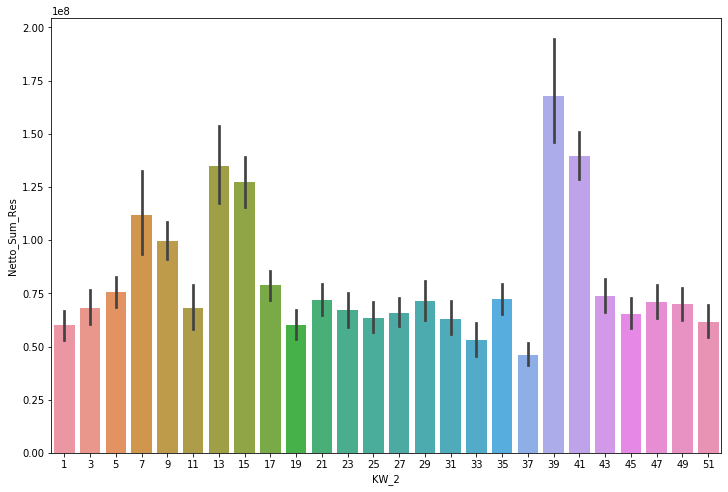

In [152]:
plt.figure(figsize=(12, 8))
sns.barplot(data=bd_aggr_2w, x='KW_2', y='Netto_Sum_Res', estimator=np.sum)

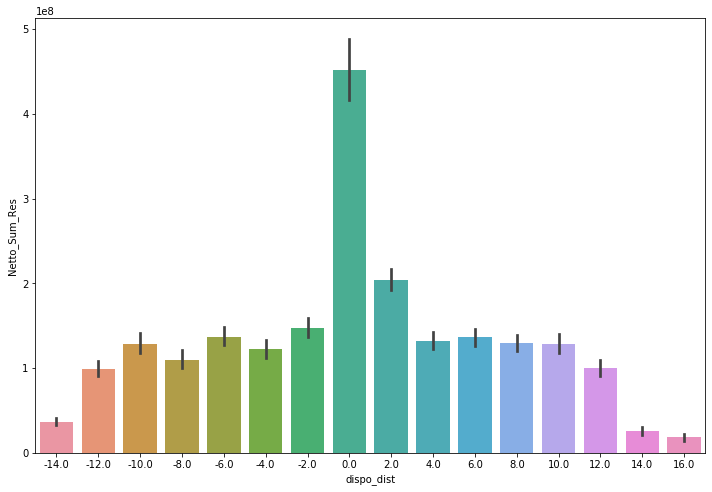

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(data=bd_aggr_2w, x='dispo_dist', y='Netto_Sum_Res', estimator=np.sum)

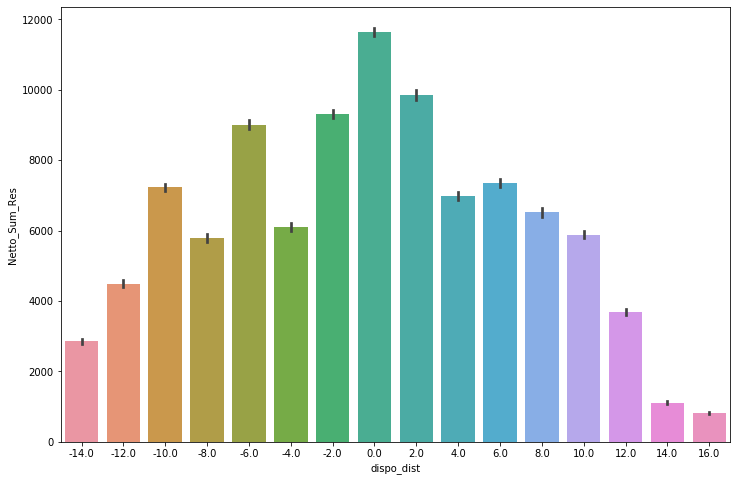

In [151]:
plt.figure(figsize=(12, 8))
sns.barplot(data=bd_aggr_2w, x='dispo_dist', y='Netto_Sum_Res', estimator=np.count_nonzero)

# Netto by customer / year

In [ ]:
bd_aggr_yr = bd_aggr_2w.groupby(["Endkunde_NR", "Jahr"]).agg(
    {"Netto_Sum_Res": "sum", "Netto_Sum_Aus": "sum"}
)

bd_aggr_yr.head(15)

In [ ]:
bd_aggr_yr_ek = bd_aggr_yr.groupby("Endkunde_NR").agg(["min", "max", "mean", "median"])

bd_aggr_yr_ek.head()

In [ ]:
np.log1p(bd_aggr_yr_ek[('Netto_Sum_Res', 'mean')]).hist()

### Find good category borders for 5 categories

In [ ]:
pd.qcut(bd_aggr_yr_ek[('Netto_Sum_Res', 'mean')].values, q=5).categories

### Cut the net values, label categories, merge back into ``ek_info_current`` 

In [ ]:
_netto_cat = pd.cut(
    bd_aggr_yr_ek[("Netto_Sum_Res", "mean")],
    bins=(0, 4000, 10000, 50000, 500000, 7000000),
    labels="<4k 4k-10k 10k-50k 50k-500k >500k".split(),
).rename("netto_cat")

ek_info_current.loc[:,'Netto_Cat'] = ek_info_current.merge(_netto_cat, on='Endkunde_NR')['netto_cat'].values

In [ ]:
ek_info_current.Netto_Cat.value_counts()

# Calculate sum curve per customer * year, over periods

In [ ]:
def make_year_grp_sumcurve(df, year_col, grp_col, data_col, prefix=""):
    # build new columns with sum/cumsum per year/grp
    df = df.pipe(
        calc_col_partitioned,
        f"{prefix}sumJahr",
        fun="sum",
        on=data_col,
        part_by=[year_col, grp_col],
    ).pipe(
        calc_col_partitioned,
        f"{prefix}cumJahr",
        fun="cumsum",
        on=data_col,
        part_by=[year_col, grp_col],
    )

    # divide data_col by sum to get scaled amounts, show in %
    df = (
        df.eval(f"{prefix}prcJahr = ({data_col} / {prefix}sumJahr) * 100 + 0.5")
        .fillna({f"{prefix}prcJahr": 0})
        .astype({f"{prefix}prcJahr": "int"})
    )

    # divide cumsum by sum to get sum curve [0, 1], show in %
    df = (
        df.eval(f"{prefix}crvJahr = ({prefix}cumJahr / {prefix}sumJahr) * 100 + 0.5")
        .fillna({f"{prefix}crvJahr": 0})
        .astype({f"{prefix}crvJahr": "int"})
    )
    return df

In [ ]:
bd_aggr_2w = (
    bd_aggr_2w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_2"])
    .reset_index(drop=True)
)

bd_aggr_4w = (
    bd_aggr_4w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_4"])
    .reset_index(drop=True)
)

In [ ]:
bd_aggr_2w.head(10)

In [ ]:
bd_aggr_4w.head(10)

### Store and reload results

In [ ]:
store_bin(bd_aggr_2w, 'bd_cluster_aggr_2w.feather')
store_bin(bd_aggr_4w, 'bd_cluster_aggr_4w.feather')

In [ ]:
bd_aggr_2w = load_bin('bd_cluster_aggr_2w.feather')
bd_aggr_4w = load_bin('bd_cluster_aggr_4w.feather')

# Clustering Customers by Reservation

### Drop incomplete years

We have data for the last 10 years, the current year is incomplete

In [ ]:
current_year = pd.Timestamp.today().year
valid_years = list(range(current_year - 10, current_year))
valid_years

### Pivot prc values by period

In [ ]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data.head(12)

### Prepare data: Aggregate over years by customer

In [ ]:
ek_2w_prc_mean = (
    bd_res_prc_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

# correct rowsums to 100
ek_2w_prc_mean = (normalize_rows(ek_2w_prc_mean) * 100)

ek_2w_prc_mean_stack = (
    ek_2w_prc_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "prc_mean"], axis="columns", inplace=False)
)

display(ek_2w_prc_mean.round(1).head(10))

### Pivot crv values by period

In [ ]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

### Aggregate over years by customer

In [ ]:
ek_2w_crv_mean = (
    bd_res_crv_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_crv_mean_stack = (
    ek_2w_crv_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "crv_mean"], axis="columns", inplace=False)
)

display(bd_res_crv_2w_data.head())
display(ek_2w_crv_mean.head())
ek_2w_crv_mean_stack.head()

### Plot customer booking patterns (global)

In [ ]:
import seaborn as sns
%matplotlib inline

sns.set()
sns.catplot(
    data=ek_2w_prc_mean_stack, x="KW_2", y="prc_mean", aspect=2.5, kind="boxen"
)

In [ ]:
sns.catplot(
    data=ek_2w_crv_mean_stack, x="KW_2", y="crv_mean", aspect=2.5, kind="boxen"
)

### Cluster booking patterns (percentage of yearly sum)

Prepare data

In [ ]:
X = ek_2w_prc_mean.to_numpy()

X_columns = ek_2w_prc_mean.columns

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(5, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

prc_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True, vmin=1, vmax=5)

Cluster sizes

In [ ]:
pd.Series(prc_nkmeans_labels).value_counts()

Plot scaled bookings by cluster

In [ ]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=prc_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.1,
    kind="boxen",
    col="cluster",
    col_wrap=4,
    col_order=pd.Series(prc_nkmeans_labels).value_counts().index,  # order by cluster size
    height=4,
)

### Cluster booking patterns (cumulative percentage of yearly sum)

Prepare data

In [ ]:
X = ek_2w_crv_mean.to_numpy()

X_columns = ek_2w_crv_mean.columns

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(3, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

crv_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(crv_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True)

Cluster sizes

In [ ]:
pd.Series(crv_nkmeans_labels).value_counts()

Plot scaled bookings by cluster

In [ ]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=crv_nkmeans_labels, index=ek_2w_crv_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    col_order=pd.Series(crv_nkmeans_labels).value_counts().index, # order by cluster size
    height=4,
)

# PCA on Customers

### Prepare Data

In [ ]:
X = ek_2w_crv_mean.to_numpy()
X_columns = ek_2w_crv_mean.columns
X_index = ek_2w_crv_mean.index

y = crv_nkmeans_labels

### Calculate standard PCA with 4 components

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, random_state=0)
X_pca = pca.fit_transform(X)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.components_

### Plot K-means clusters against principal components

In [ ]:
plot_data = pd.DataFrame(X_pca, index=X_index, columns=range(1, pca.n_components + 1))
plot_data["clusters"] = y
sns.set(style="ticks")
sns.pairplot(data=plot_data, hue="clusters", plot_kws={"alpha": 0.4})

# Clustering Customer Booking Years

### Prepare data: Pivot prc values by period

In [ ]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data_stack = bd_res_prc_2w_data.stack()

bd_res_prc_2w_data.head(12)

In [ ]:
X = bd_res_prc_2w_data.to_numpy()

X_columns = bd_res_prc_2w_data.columns
X_index = bd_res_prc_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(25, 31):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_prc_nkmeans_labels = nkmeans.fit_predict(X)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_prc_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(yr_prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(25, 16))
sns.heatmap(yr_prc_nkmeans_clusters, annot=True, vmin=0, vmax=7)

In [ ]:
pd.Series(yr_prc_nkmeans_labels).value_counts() # / yr_prc_nkmeans_labels.shape[0]

In [ ]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [ ]:
ek_prc_cls = pd.crosstab(
    index=bd_res_prc_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_prc_nkmeans_labels, name="cluster"),
)

ek_prc_cls_yr_cnt_ = ek_prc_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_prc_cls = ek_prc_cls.assign(
    n_yr=ek_prc_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_prc_cls_yr_cnt_.where(ek_prc_cls > 0).count(axis="columns"),
    cls=ek_prc_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_prc_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_prc_cls["n_main_cls"] = ek_prc_cls["main_cls"].apply(len)

ek_prc_cls

### Customers that can be related to 1 or 2 clusters

In [ ]:
max_main_cls = 2

ek_clust_scoring = ek_prc_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

### Prepare data: Pivot crv values by period

In [ ]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

bd_res_crv_2w_data_stack = bd_res_crv_2w_data.stack()

bd_res_crv_2w_data.head(12)

### Prepare for clustering

In [ ]:
X = bd_res_crv_2w_data.to_numpy()

X_columns = bd_res_crv_2w_data.columns
X_index = bd_res_crv_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in [15, 25, 35, 40]:
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

```
For n_clusters = 5: Silhouette_score = 0.3049945347740261,  CH score = 29630.89896114061
For n_clusters = 10: Silhouette_score = 0.366230862992324,  CH score = 26973.062027368196
For n_clusters = 15: Silhouette_score = 0.40334656127747526,  CH score = 25417.006073311764
For n_clusters = 20: Silhouette_score = 0.44202548618962784,  CH score = 24818.708849953175
For n_clusters = 25: Silhouette_score = 0.5033501558327148,  CH score = 24748.31007457299
For n_clusters = 30: Silhouette_score = 0.5602936199726821,  CH score = 25025.39923837368
For n_clusters = 35: Silhouette_score = 0.6095264482491675,  CH score = 26642.345879735167
For n_clusters = 40: Silhouette_score = 0.6171105582735361,  CH score = 26586.30470955651
```

In [ ]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_crv_nkmeans_labels = nkmeans.fit_predict(X)

### Show cluster centroids

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns)

plt.figure(figsize=(25, 16))
sns.heatmap(yr_nkmeans_clusters, annot=True, vmin=5)

### Cluster sizes

In [ ]:
pd.Series(yr_crv_nkmeans_labels).value_counts()

In [ ]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_crv_nkmeans_labels, index=bd_res_crv_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [ ]:
ek_cls = pd.crosstab(
    index=bd_res_crv_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_crv_nkmeans_labels, name="cluster"),
)

ek_cls_yr_cnt_ = ek_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_cls = ek_cls.assign(
    n_yr=ek_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_cls_yr_cnt_.where(ek_cls > 0).count(axis="columns"),
    cls=ek_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_cls["n_main_cls"] = ek_cls["main_cls"].apply(len)

ek_cls

### Customers that can be assigned to 1 or 2 clusters

In [ ]:
max_main_cls = 2

yr_clust_scoring = ek_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

# Compare scoring between customer layer and year layer

In [ ]:
len(np.unique(ek_clust_scoring.index.values))

In [ ]:
len(np.unique(yr_clust_scoring.index.values))

In [ ]:
pd.DataFrame({"ek": np.unique(ek_clust_scoring.index.values)}).merge(
    pd.DataFrame({"ek": np.unique(yr_clust_scoring.index.values)}),
    how="outer",
    on="ek",
    indicator=True,
)["_merge"].value_counts()

# Cluster Scoring vs. Auftragsart

In [ ]:
AufArt_Clust = (
    ek_auftragsart_scoring.merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust)

In [ ]:
plt.figure(figsize=(16, 20))
sns.heatmap(
    data=np.log1p(pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust)),
    annot=pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust),
    fmt="d"
)

# Cluster Scoring vs. Branchengruppe

In [ ]:
BG_Clust = (
    ek_branchen_scoring.merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG, margins=True)

In [ ]:
plt.figure(figsize=(16, 32))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG)),
    annot=pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG),
    fmt="d",
    vmax=0.4
)

# Cluster Scoring vs. Kanton

In [ ]:
with project_dir('Raumgliederung'):
    ek_region = load_bin('ek_region.feather')

In [ ]:
ek_region.head()

In [ ]:
Kt_Clust = (
    ek_region[["Endkunde_NR", "KANTON"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Kt_Clust.Clust, index=Kt_Clust.KANTON)),
    annot=pd.crosstab(columns=Kt_Clust.Clust, index=Kt_Clust.KANTON),
    fmt="d",
    #vmax=0.4
)

# Cluster Scoring vs. Grossregion

In [ ]:
GrReg_Clust = (
    ek_region[["Endkunde_NR", "GROSSREGION"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=GrReg_Clust.Clust, index=GrReg_Clust.GROSSREGION)),
    annot=pd.crosstab(columns=GrReg_Clust.Clust, index=GrReg_Clust.GROSSREGION),
    fmt="d",
)

# Cluster Scoring vs. Region

In [ ]:
Reg_Clust = (
    ek_region[["Endkunde_NR", "REGION"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 32))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Reg_Clust.Clust, index=Reg_Clust.REGION)),
    annot=pd.crosstab(columns=Reg_Clust.Clust, index=Reg_Clust.REGION),
    fmt="d",
)

# Cluster Scoring vs. Netto-Umsatz

In [ ]:
Netto_Clust = (
    ek_info_current[["Endkunde_NR", "netto_cat"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Netto_Clust.Clust, index=Netto_Clust.netto_cat)),
    annot=pd.crosstab(columns=Netto_Clust.Clust, index=Netto_Clust.netto_cat),
    fmt="d",
)

# Map cluster scorings to periods, where appropriate

## Years, clustered by prc

In [ ]:
ek_clusters = (pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="yr_prc_clust"
        ),
        on=["Endkunde_NR", "Jahr"],
    ))

ek_clusters.head()